## Set up

In [1]:
import sys
sys.path.append('./scripts/')
import os
import matplotlib.pyplot as plt
import seaborn as sns
import math
import copy
import numpy as np
sns.set_style("darkgrid")
from PIL import Image
import random # random seed to reproduce MDS and t-SNE plots

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn import manifold # MDS and t-SNE
from sklearn import cluster # k-Means clustering
from sklearn import preprocessing # scaling attributes
from sklearn.metrics import silhouette_score # silhouette width for clustering
from sklearn.cluster import DBSCAN
import hdbscan
import umap

import torch
import torchvision

import imp
import my_datasets
import utilities 
imp.reload(my_datasets) 
imp.reload(utilities) 

plt.rcParams["figure.figsize"] = (3,3)

/tmp/ipykernel_40606/3815746407.py:27: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp


In [2]:
random.seed(2021)

In [3]:
dataset='ilsvrc12fine'
paths, count, y, idx_to_labels = my_datasets.get_dataset(dataset)

print(count, len(paths))

1281167 1281167


In [4]:
# For ilsvrc12fine dataset, paths are mapped differently
if dataset=='ilsvrc12fine':
    idxs= np.arange(0, 1281167, 10) 
    classes = np.unique(y[idxs])
    ppaths=[paths[i] for i in idxs]
    paths=ppaths

In [5]:
layer='Mixed_7b.cat_2'
SAVEFOLD0=f'../outputs/{dataset}'

SAVEFOLD=f"{SAVEFOLD0}/{layer}/"

In [6]:
#gradients_wrt_conv_layer=np.load(f"{SAVEFOLD}/gradients_wrt_conv_layer.npy")
predictions=np.load(f"{SAVEFOLD}/predictions.npy", mmap_mode = 'r')
conv_maps=np.load(f"{SAVEFOLD}/conv_maps.npy", mmap_mode = 'r')

# pvh=np.load(f"{SAVEFOLD}/eigenvectors.npy",allow_pickle=True, mmap_mode = 'r')

In [7]:
transforms = "standardise" # None / "standardise" / "normalise"

In [8]:
conv_maps_avg = conv_maps.mean(3).mean(2)

In [9]:
scale = StandardScaler()
normalise = MinMaxScaler()

standardised_data = scale.fit_transform(conv_maps_avg) 
normalised_data = normalise.fit_transform(conv_maps_avg) # .shape (10000, 2048)

In [10]:
if transforms == "standardise":
    activations = standardised_data
    print("Standardise")
elif transforms == "normalise": 
    activations = normalised_data
    print("Normaliseise")
else: 
    activations = conv_maps_avg
    print("Raw activations")

Standardise


In [11]:
# conv_maps_avg

In [12]:
# activations

## Utilities

Scatterplot to visualise clusters

In [13]:
colors = np.array(['orange', 'blue', 'lime', 'khaki', 'pink', 
                   'green', 'purple', 'yellow'])

# points - a 2D array of (x,y) coordinates of data points
# labels - an array of numeric labels in the interval [0..k-1], one for each point
# centers - a 2D array of (x, y) coordinates of cluster centers
# title - title of the plot
def clustering_scatterplot(points, labels, centers, title):
    n_clusters = np.unique(labels).size
    for i in range(n_clusters):
        h = plt.scatter(points[labels==i,0],
                        points[labels==i,1], 
                        c=colors[i%colors.size],
                        label = 'cluster '+str(i))
    # plot the centers of the clusters
    if centers is not None:
        plt.scatter(centers[:,0], centers[:,1], c='r', marker='*', s=500)
    
    _ = plt.title(title)
    _ = plt.legend()
    _ = plt.xlabel('x')
    _ = plt.ylabel('y')

## Clustering

In [14]:
neuron = 1
top = 100
top_ims = utilities.get_activations(activations_avg = activations, direction = neuron).argsort()[-top:][::-1] 

top_activations = utilities.get_activations(activations_avg = activations, ims=top_ims)
top_activations.shape # (25, 2048)
# top_activations

(100, 2048)

How many clusters for kmeans?

Plot the sum of squared distances from the data points to the centers of the k-Means clusters for various values of k. Use the Elbow method to pick the best value of k. 

In [15]:
kmax = 10

In [16]:
sse = {}
for k in range(1,kmax):
        kmeans = cluster.KMeans(n_clusters=k, n_init=10, max_iter=1000, 
                                random_state=1).fit(top_activations)
        sse[k] = kmeans.inertia_ 
        # Inertia: Sum of distances of samples to their closest cluster center
        # label = kmeans.labels_
        # sil_coeff[k] = silhouette_score(data, label, metric='euclidean')

In [17]:
sse

{1: 169707.61630742782,
 2: 150390.5299930565,
 3: 142729.6491381957,
 4: 135739.46332198541,
 5: 132677.88094295072,
 6: 126755.33968231225,
 7: 120140.10452142624,
 8: 117493.89250837849,
 9: 115355.39415286026}

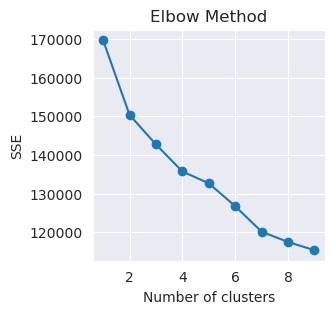

In [18]:
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()), 'o-')
plt.xlabel("Number of clusters")
plt.ylabel("SSE")
plt.title("Elbow Method")
plt.show()

In [19]:
sil_coeff = {}
for k in range(2,kmax):
    random.seed(1)
    kmeans = cluster.KMeans(n_clusters=k, n_init=10, max_iter=1000,
                            random_state=2021).fit(top_activations)
    label = kmeans.labels_
    sil_coeff[k] = silhouette_score(top_activations, label, metric='euclidean')

In [20]:
sil_coeff

{2: 0.1279063327814932,
 3: 0.03000686677353405,
 4: 0.03695971451274421,
 5: 0.07485741262485553,
 6: 0.07781560391633008,
 7: 0.07110945380438295,
 8: 0.021130023411158234,
 9: 0.024234215177877085}

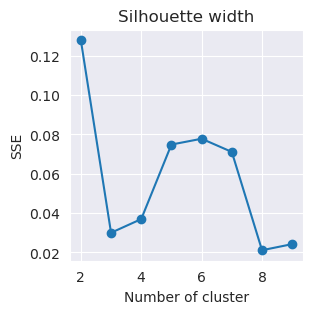

In [21]:
plt.figure()
plt.plot(list(sil_coeff.keys()), list(sil_coeff.values()), "o-")
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.title("Silhouette width")
plt.show()

## Dimensionality reduction

/home/laura/anaconda3/envs/sw-interpretability/lib/python3.8/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


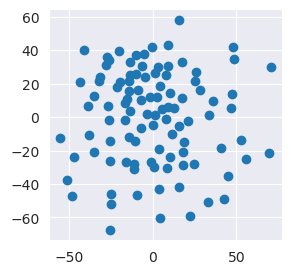

In [22]:
XY_MDS = manifold.MDS(n_components=2).fit_transform(top_activations)
plt.scatter(x=XY_MDS[:,0],y=XY_MDS[:,1])

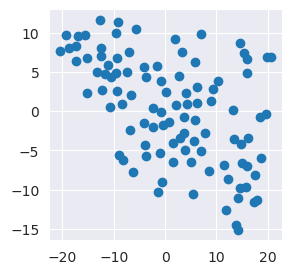

In [23]:
XY_TSNE = manifold.TSNE(n_components=2,perplexity=10).fit_transform(top_activations)
plt.scatter(x=XY_TSNE[:,0],y=XY_TSNE[:,1])

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


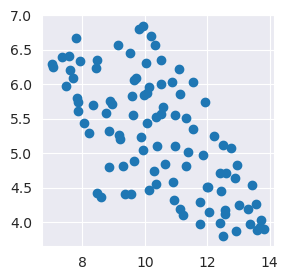

In [24]:
XY_UMAP = umap.UMAP(n_components=2).fit_transform(top_activations)
plt.scatter(x=XY_UMAP[:,0],y=XY_UMAP[:,1])

## Find number of clusters

In [25]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics.pairwise import pairwise_distances

In [26]:
clusterer = AgglomerativeClustering(n_clusters=None,distance_threshold=50, metric='euclidean', linkage='ward')
clusterer.fit_predict(top_activations)

array([17, 28,  8,  3,  0,  4,  0, 14, 17, 14,  0,  3,  3, 23,  6,  3,  3,
       13,  8,  8,  7,  3,  0,  0, 14, 17, 43, 39,  3, 40,  1,  0,  0,  6,
        1, 21, 25,  3,  6, 17, 17,  1,  4, 41, 17, 17,  7,  5, 33, 17,  3,
       13, 17,  6,  3, 17, 42,  1, 22,  7,  8,  3, 14, 10, 26,  2, 37, 31,
        6,  3, 34, 32, 29, 27, 15,  5, 14, 20,  7,  3, 38,  0, 14, 35, 30,
       24,  3, 11, 14, 12, 19,  3, 18, 16,  2,  8,  7,  9,  7, 36])

[[ 0.         71.76381489 47.37730222 ... 69.12336987 55.92155628
  62.13135439]
 [71.76381489  0.         64.95986578 ... 83.68755403 68.22498248
  86.27205263]
 [47.37730222 64.95986578  0.         ... 69.46550213 51.20961247
  65.48379417]
 ...
 [69.12336987 83.68755403 69.46550213 ...  0.         72.10424985
  78.15525611]
 [55.92155628 68.22498248 51.20961247 ... 72.10424985  0.
  73.96788237]
 [62.13135439 86.27205263 65.48379417 ... 78.15525611 73.96788237
   0.        ]]


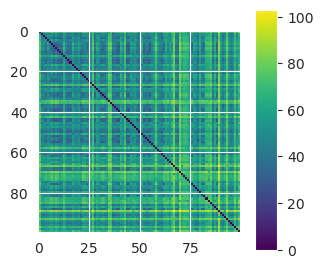

In [27]:
distance_matrix = pairwise_distances(top_activations, metric = 'euclidean')
print(distance_matrix)

ax = plt.subplot()
im = ax.imshow(distance_matrix, cmap='viridis', interpolation='nearest') 
plt.subplots_adjust(right=0.8)
cbar_ax = plt.axes([0.85, 0.1, 0.075, 0.8])
plt.colorbar(mappable=(im), cax=cbar_ax)
plt.show() 

In [73]:
clusterer = AgglomerativeClustering(n_clusters=None,distance_threshold=180, metric='euclidean', linkage='ward')
clusterer.fit_predict(top_activations)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


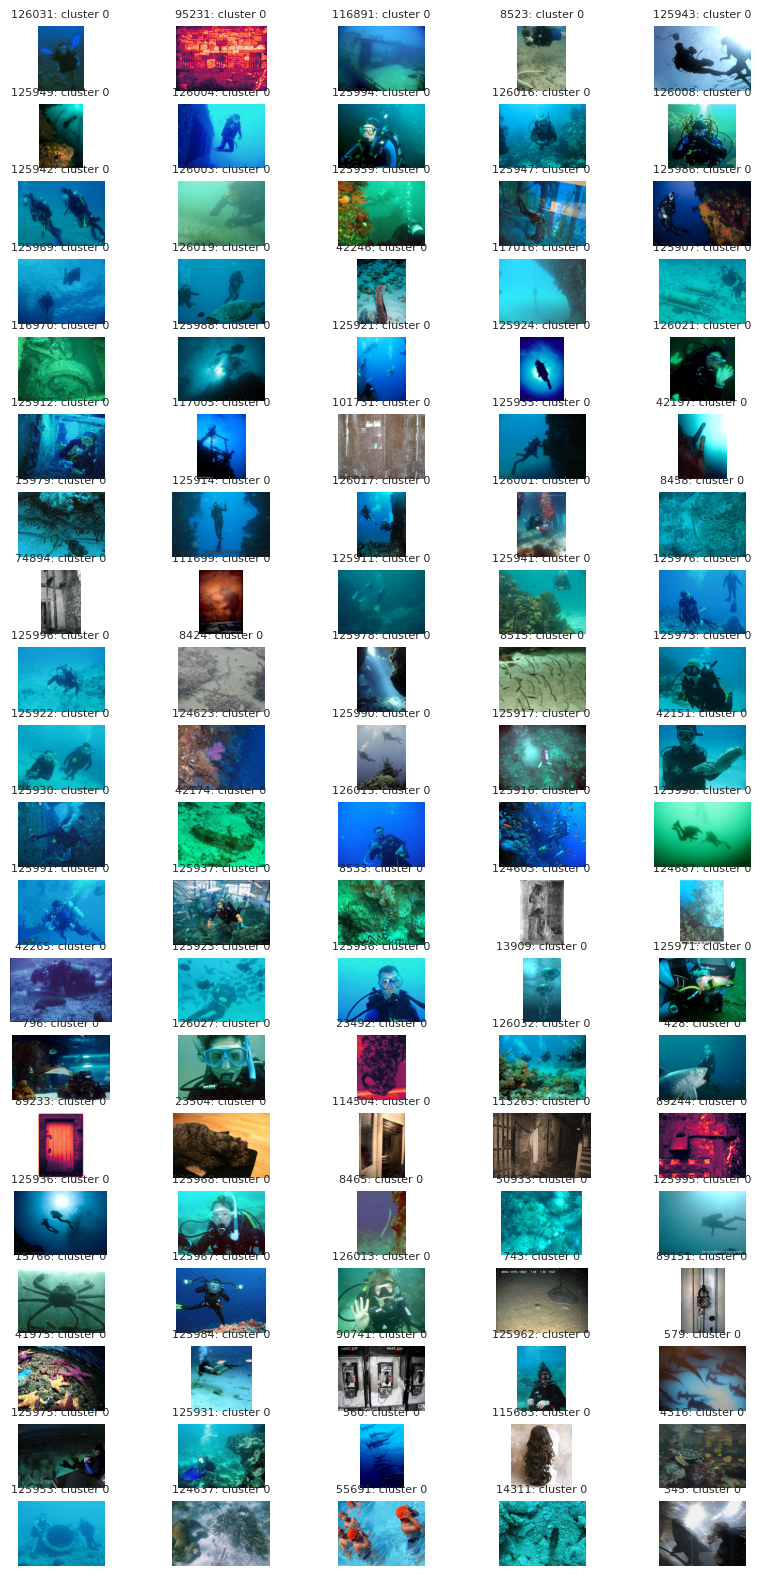

In [74]:
clu_labs = clusterer.labels_
print(clu_labs)
clu_lab_order = sorted(range(len(clu_labs)), key=lambda k: clu_labs[k])

fig, ax = plt.subplots(math.ceil(len(top_ims)//5), 5, figsize = (10,20))
ax = ax.flatten()
for idx, im_id in enumerate(top_ims[clu_lab_order]):
    im = Image.open(paths[im_id])
    ax[idx].imshow(im)
    ax[idx].set_title(f"{im_id}: cluster {clu_labs[clu_lab_order][idx]}", size = 8)
    ax[idx].axis('off')

In [ ]:
end

[ 1 -1  2 -1 -1 -1  1  1  1  1  1 -1  2  2  2 -1  1  0 -1  2 -1  2  1 -1
  1 -1 -1  2  2 -1  0  1  1  1 -1 -1  2  2  2  1  1  0  2  0  1  1  0 -1
  2  1  2  0  1 -1 -1  1 -1  0 -1  0  2  2  1  2  1  2  1 -1 -1 -1 -1 -1
  2  2  2  2  1  0  0  2  2  1  1  0  2  0  2  2  1 -1  2  2  2 -1  0  2
  0  2  0 -1]


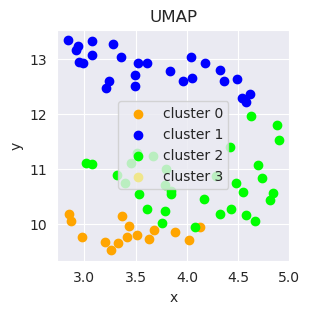

In [30]:
# HDBSCAN doesn't work for top_activations, UMAP 2D, UMAP 10 D
XY_UMAP = umap.UMAP(n_components=3).fit_transform(top_activations) # CHANGE
clusterer = hdbscan.HDBSCAN() # allow_single_cluster = True
clusterer.fit(XY_UMAP) # top_activations
print(clusterer.labels_)
clustering_scatterplot(points=XY_UMAP, 
                       labels=clusterer.labels_,
                       centers=None, 
                       title='UMAP')

In [31]:
clu_labs = clusterer.labels_
print(clu_labs)
clu_lab_order = sorted(range(len(clu_labs)), key=lambda k: clu_labs[k])

fig, ax = plt.subplots(math.ceil(len(top_ims)//5), 5, figsize = (10,20))
ax = ax.flatten()
for idx, im_id in enumerate(top_ims[clu_lab_order]):
    im = Image.open(paths[im_id])
    ax[idx].imshow(im)
    ax[idx].set_title(f"{im_id}: cluster {clu_labs[clu_lab_order][idx]}", size = 8)
    ax[idx].axis('off')

[ 1 -1  2 -1 -1 -1  1  1  1  1  1 -1  2  2  2 -1  1  0 -1  2 -1  2  1 -1
  1 -1 -1  2  2 -1  0  1  1  1 -1 -1  2  2  2  1  1  0  2  0  1  1  0 -1
  2  1  2  0  1 -1 -1  1 -1  0 -1  0  2  2  1  2  1  2  1 -1 -1 -1 -1 -1
  2  2  2  2  1  0  0  2  2  1  1  0  2  0  2  2  1 -1  2  2  2 -1  0  2
  0  2  0 -1]
Error in callback <function flush_figures at 0x7fcef47291f0> (for post_execute):


KeyboardInterrupt: 

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


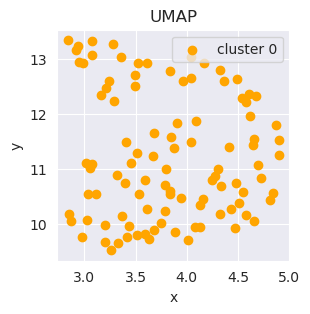

In [32]:
# clustered_data_sklearn = DBSCAN(eps=10).fit(top_activations) # , metric = "cosine"
# print(clustered_data_sklearn.labels_)
# clustered_data_sklearn

# DBSCAN doesn't work for top_activations, UMAP 2D, UMAP 10D, cosine UMAP 2D, cosine UMAP 10D
clusterer = DBSCAN(metric = "cosine") 
clusterer.fit(XY_UMAP) # top_activations
print(clusterer.labels_)
clustering_scatterplot(points=XY_UMAP, 
                       labels=clusterer.labels_,
                       centers=None, 
                       title='UMAP')

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


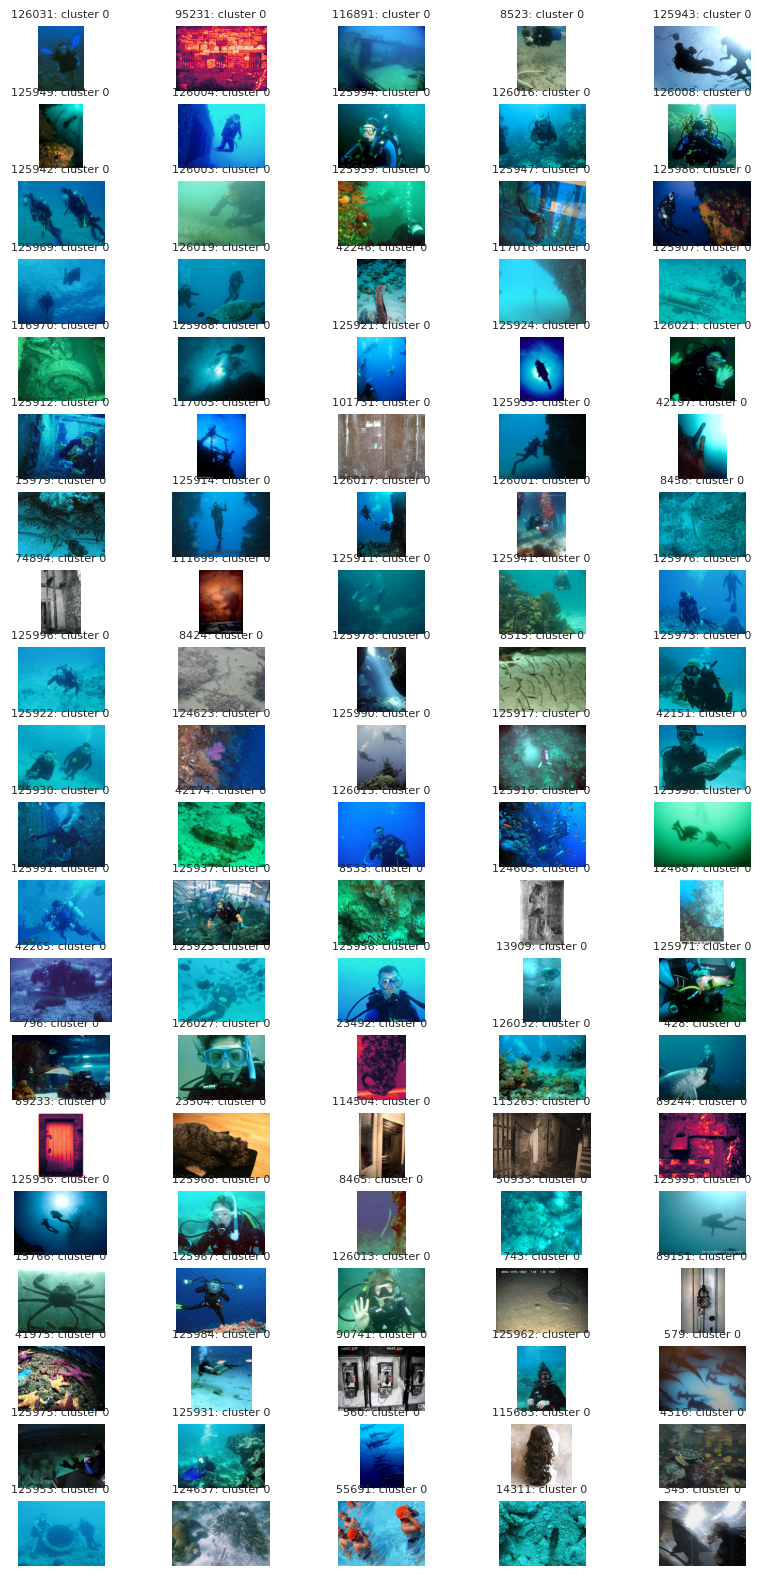

In [33]:
clu_labs = clusterer.labels_
print(clu_labs)
clu_lab_order = sorted(range(len(clu_labs)), key=lambda k: clu_labs[k])

fig, ax = plt.subplots(math.ceil(len(top_ims)//5), 5, figsize = (10,20))
ax = ax.flatten()
for idx, im_id in enumerate(top_ims[clu_lab_order]):
    im = Image.open(paths[im_id])
    ax[idx].imshow(im)
    ax[idx].set_title(f"{im_id}: cluster {clu_labs[clu_lab_order][idx]}", size = 8)
    ax[idx].axis('off')

In [34]:
# # 
# distance_matrix = pairwise_distances(top_activations, metric = 'euclidean')
# clusterer = hdbscan.HDBSCAN(metric='precomputed', allow_single_cluster = True)
# clusterer.fit(distance_matrix)
# print(clusterer.labels_)
# print(distance_matrix)
# print(np.min(distance_matrix[np.nonzero(distance_matrix)]))
# clustering_scatterplot(points=XY_UMAP, 
#                        labels=clusterer.labels_,
#                        centers=None, 
#                        title='UMAP')

## Analyse n_clusters clusters

In [35]:
n_clusters = 2

Increased the max_iter to 1000 to allow the algorithm more time to converge. 
Increased n_init to run the algorithm more times with various random seeds. 
The final results is then the best output of 100 consecutive runs in terms of inertia.

https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

In [36]:
# Append the cluster centers to the dataset.
clustered_data_sklearn = KMeans(n_clusters=n_clusters, n_init=100, max_iter=1000).fit(top_activations)

In [37]:
data_and_centers = np.r_[top_activations,clustered_data_sklearn.cluster_centers_]

In [38]:
top_activations

array([[ 2.16439982e-01,  1.58278530e+01, -9.60170728e-01, ...,
        -5.59571139e-03, -2.64030085e-01, -4.42895638e-01],
       [-7.27886952e-01,  1.55831172e+01, -1.04378485e+00, ...,
        -4.29447656e-01,  1.25842583e+00, -4.86000322e-01],
       [ 3.40003139e-02,  1.51069180e+01, -6.54252416e-01, ...,
        -4.29447656e-01, -5.30286633e-01, -4.86000322e-01],
       ...,
       [ 7.67709871e-01,  8.79855449e+00,  1.70730401e-01, ...,
         1.49933562e+00, -1.42793817e-01, -3.35388644e-01],
       [ 1.31948757e-02,  8.77426654e+00, -6.72995333e-01, ...,
        -4.29447656e-01, -2.52142807e-01, -4.86000322e-01],
       [ 4.63344487e-01,  8.75778666e+00, -6.99721589e-01, ...,
        -3.57305901e-01, -4.35633541e-01,  8.75728845e-01]])

Apply a manifold-learning technique to project the data set to a 2D space. 

In [39]:
# Apply multi-dimensional scaling (MDS) to project both the data and the k-Means cluster centers to a 2D space
XYcoordinates = manifold.MDS(n_components=2).fit_transform(data_and_centers)
print("transformation complete")

/home/laura/anaconda3/envs/sw-interpretability/lib/python3.8/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


transformation complete


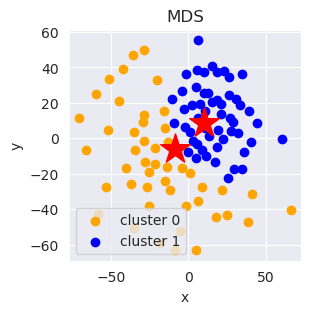

In [40]:
clustering_scatterplot(points=XYcoordinates[:-n_clusters,:], 
                       labels=clustered_data_sklearn.labels_, 
                       centers=XYcoordinates[-n_clusters:,:], 
                       title='MDS')

In [41]:
# Apply t-SNE to project both the data and the k-Means cluster centers to a 2D space


In [42]:
XYcoordinates = manifold.TSNE(n_components=2, perplexity=10).fit_transform(data_and_centers)
print("transformation complete")

transformation complete


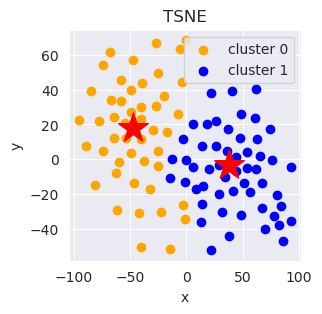

In [43]:
clustering_scatterplot(points=XYcoordinates[:-n_clusters,:], 
                       labels=clustered_data_sklearn.labels_,
                       centers=XYcoordinates[-n_clusters:,:], 
                       title='TSNE')

It is unclear exactly where the elbow is here. I will therefore look at the average silhouette width for different numbers of clusters. This gives a measure of how well defined clusters are (points in clusters being more similar and points in different clusters being more different). 

In [44]:
clu_labs = clustered_data_sklearn.labels_
# clu_labs

In [45]:
# fig, ax = plt.subplots(math.ceil(len(top_ims)//5), 5)
# ax = ax.flatten()
# for idx, im_id in enumerate(top_ims):
#     im = Image.open(paths[im_id])
#     ax[idx].imshow(im)
#     ax[idx].set_title(f"{im_id}: cluster {clu_labs[idx]}", size = 8)
#     ax[idx].axis('off')

In [46]:
clu_lab_order = sorted(range(len(clustered_data_sklearn.labels_)), key=lambda k: clustered_data_sklearn.labels_[k])
# clu_lab_order

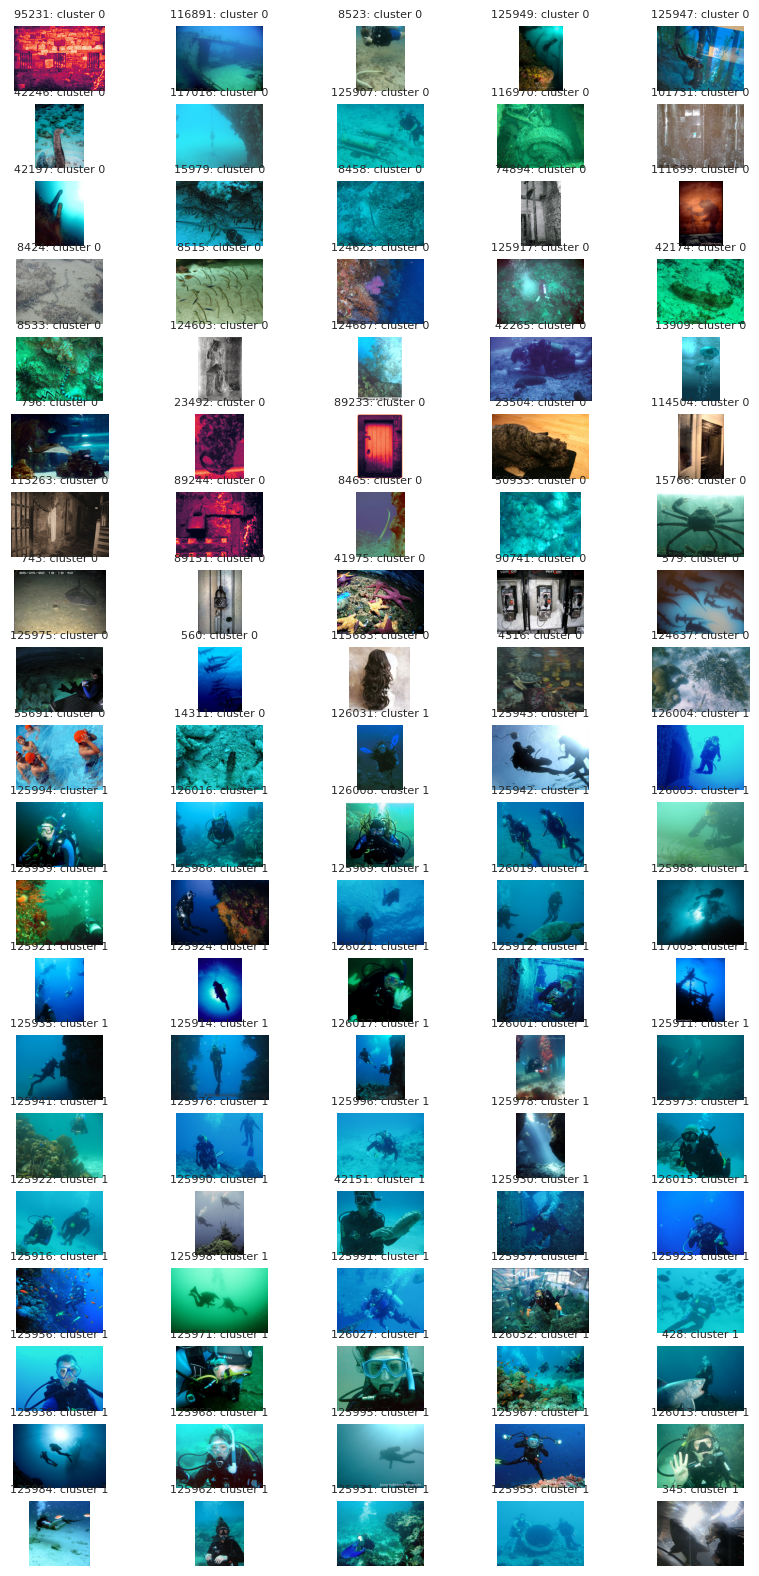

In [47]:
fig, ax = plt.subplots(math.ceil(len(top_ims)//5), 5, figsize = (10,20))
ax = ax.flatten()
for idx, im_id in enumerate(top_ims[clu_lab_order]):
    im = Image.open(paths[im_id])
    ax[idx].imshow(im)
    ax[idx].set_title(f"{im_id}: cluster {clu_labs[clu_lab_order][idx]}", size = 8)
    ax[idx].axis('off')

In [48]:
# clu_lab_order

# clu_labs[clu_lab_order] # array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
#        1, 1, 1], dtype=int32)

# for idx, im_id in enumerate(top_ims[clu_lab_order]):
#     print(im_id)

## Save images

In [49]:
# create and empty folders
if not os.path.exists(f'{SAVEFOLD}concept_ims_neuron_{neuron}/'):
    os.mkdir(f'{SAVEFOLD}concept_ims_neuron_{neuron}/')
if not os.path.exists(f'{SAVEFOLD}concept_ims_neuron_{neuron}/top_ims/'):
    os.mkdir(f'{SAVEFOLD}concept_ims_neuron_{neuron}/top_ims')
        
folder = f'{SAVEFOLD}concept_ims_neuron_{neuron}/top_ims/'
for filename in os.listdir(folder):
    file_path = os.path.join(folder, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
    except Exception as e:
        print('Failed to delete %s. Reason: %s' % (file_path, e))

In [50]:
# create and empty folders for top images
if not os.path.exists(f'{SAVEFOLD}concept_ims_neuron_{neuron}/'):
    os.mkdir(f'{SAVEFOLD}concept_ims_neuron_{neuron}/')
if not os.path.exists(f'{SAVEFOLD}concept_ims_neuron_{neuron}/top_ims/'):
    os.mkdir(f'{SAVEFOLD}concept_ims_neuron_{neuron}/top_ims')
        
folder = f'{SAVEFOLD}concept_ims_neuron_{neuron}/top_ims/'
for filename in os.listdir(folder):
    file_path = os.path.join(folder, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
    except Exception as e:
        print('Failed to delete %s. Reason: %s' % (file_path, e))
# create and empty folders for concepts    
concepts = ["cluster_0", "cluster_1", "random_0", "random_1"]
for concept in concepts:
    if not os.path.exists(f'{SAVEFOLD}concept_ims_neuron_{neuron}/{concept}/'):
        os.mkdir(f'{SAVEFOLD}concept_ims_neuron_{neuron}/{concept}/')
    folder = f'{SAVEFOLD}concept_ims_neuron_{neuron}/{concept}/'
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print('Failed to delete %s. Reason: %s' % (file_path, e))

In [51]:
# populate folders
for idx, im_id in enumerate(top_ims[clu_lab_order]):
    im = Image.open(paths[im_id])
    im.save(f"{SAVEFOLD}concept_ims_neuron_{neuron}/top_ims/{os.path.basename(os.path.normpath(paths[im_id]))}")

for idx, im_id in enumerate(top_ims[clu_lab_order]):
    if clu_labs[clu_lab_order][idx] == 0:
        im = Image.open(paths[im_id])
        im.save(f"{SAVEFOLD}concept_ims_neuron_{neuron}/cluster_0/{os.path.basename(os.path.normpath(paths[im_id]))}")
    elif clu_labs[clu_lab_order][idx] == 1:
        im = Image.open(paths[im_id])
        im.save(f"{SAVEFOLD}concept_ims_neuron_{neuron}/cluster_1/{os.path.basename(os.path.normpath(paths[im_id]))}")

In [52]:
# populate folders of random images to test concepts against
for i in range(len(os.listdir(f"{SAVEFOLD}concept_ims_neuron_{neuron}/cluster_0/"))):
    rand = random.randint(0, len(paths))
    im = Image.open(paths[rand])
    im.save(f"{SAVEFOLD}concept_ims_neuron_{neuron}/random_0/{os.path.basename(os.path.normpath(paths[rand]))}")
for i in range(len(os.listdir(f"{SAVEFOLD}concept_ims_neuron_{neuron}/cluster_1/"))):
    rand = random.randint(0, len(paths))
    im = Image.open(paths[rand])
    im.save(f"{SAVEFOLD}concept_ims_neuron_{neuron}/random_1/{os.path.basename(os.path.normpath(paths[rand]))}")

## Try testing significance using TCAV

In [53]:
from captum.concept import TCAV
from captum.concept import Concept

from captum.concept._utils.data_iterator import dataset_to_dataloader, CustomIterableDataset
from captum.concept._utils.common import concepts_to_str

In [54]:
transform = torchvision.transforms.Compose([
 torchvision.transforms.Resize(299),
 torchvision.transforms.CenterCrop(299),
 torchvision.transforms.ToTensor()
])

transform_normalize = torchvision.transforms.Normalize(
     mean=[0.485, 0.456, 0.406],
     std=[0.229, 0.224, 0.225]
 )

In [55]:
def assemble_concept(name, id, concepts_path):
    concept_path = os.path.join(concepts_path, name) + "/"
    dataset = CustomIterableDataset(get_tensor_from_filename, concept_path)
    concept_iter = dataset_to_dataloader(dataset)

    return Concept(id=id, name=name, data_iter=concept_iter)

In [56]:
def get_tensor_from_filename(filename):
    img = Image.open(filename).convert("RGB")
    return transform(img)

In [57]:
concepts_path = f'{SAVEFOLD}concept_ims_neuron_{neuron}/'

cl0_concept = assemble_concept("cluster_0", 0, concepts_path=concepts_path)
cl1_concept = assemble_concept("cluster_1", 1, concepts_path=concepts_path)

rand0_concept = assemble_concept("random_0", 2, concepts_path=concepts_path)
rand1_concept = assemble_concept("random_1", 3, concepts_path=concepts_path)

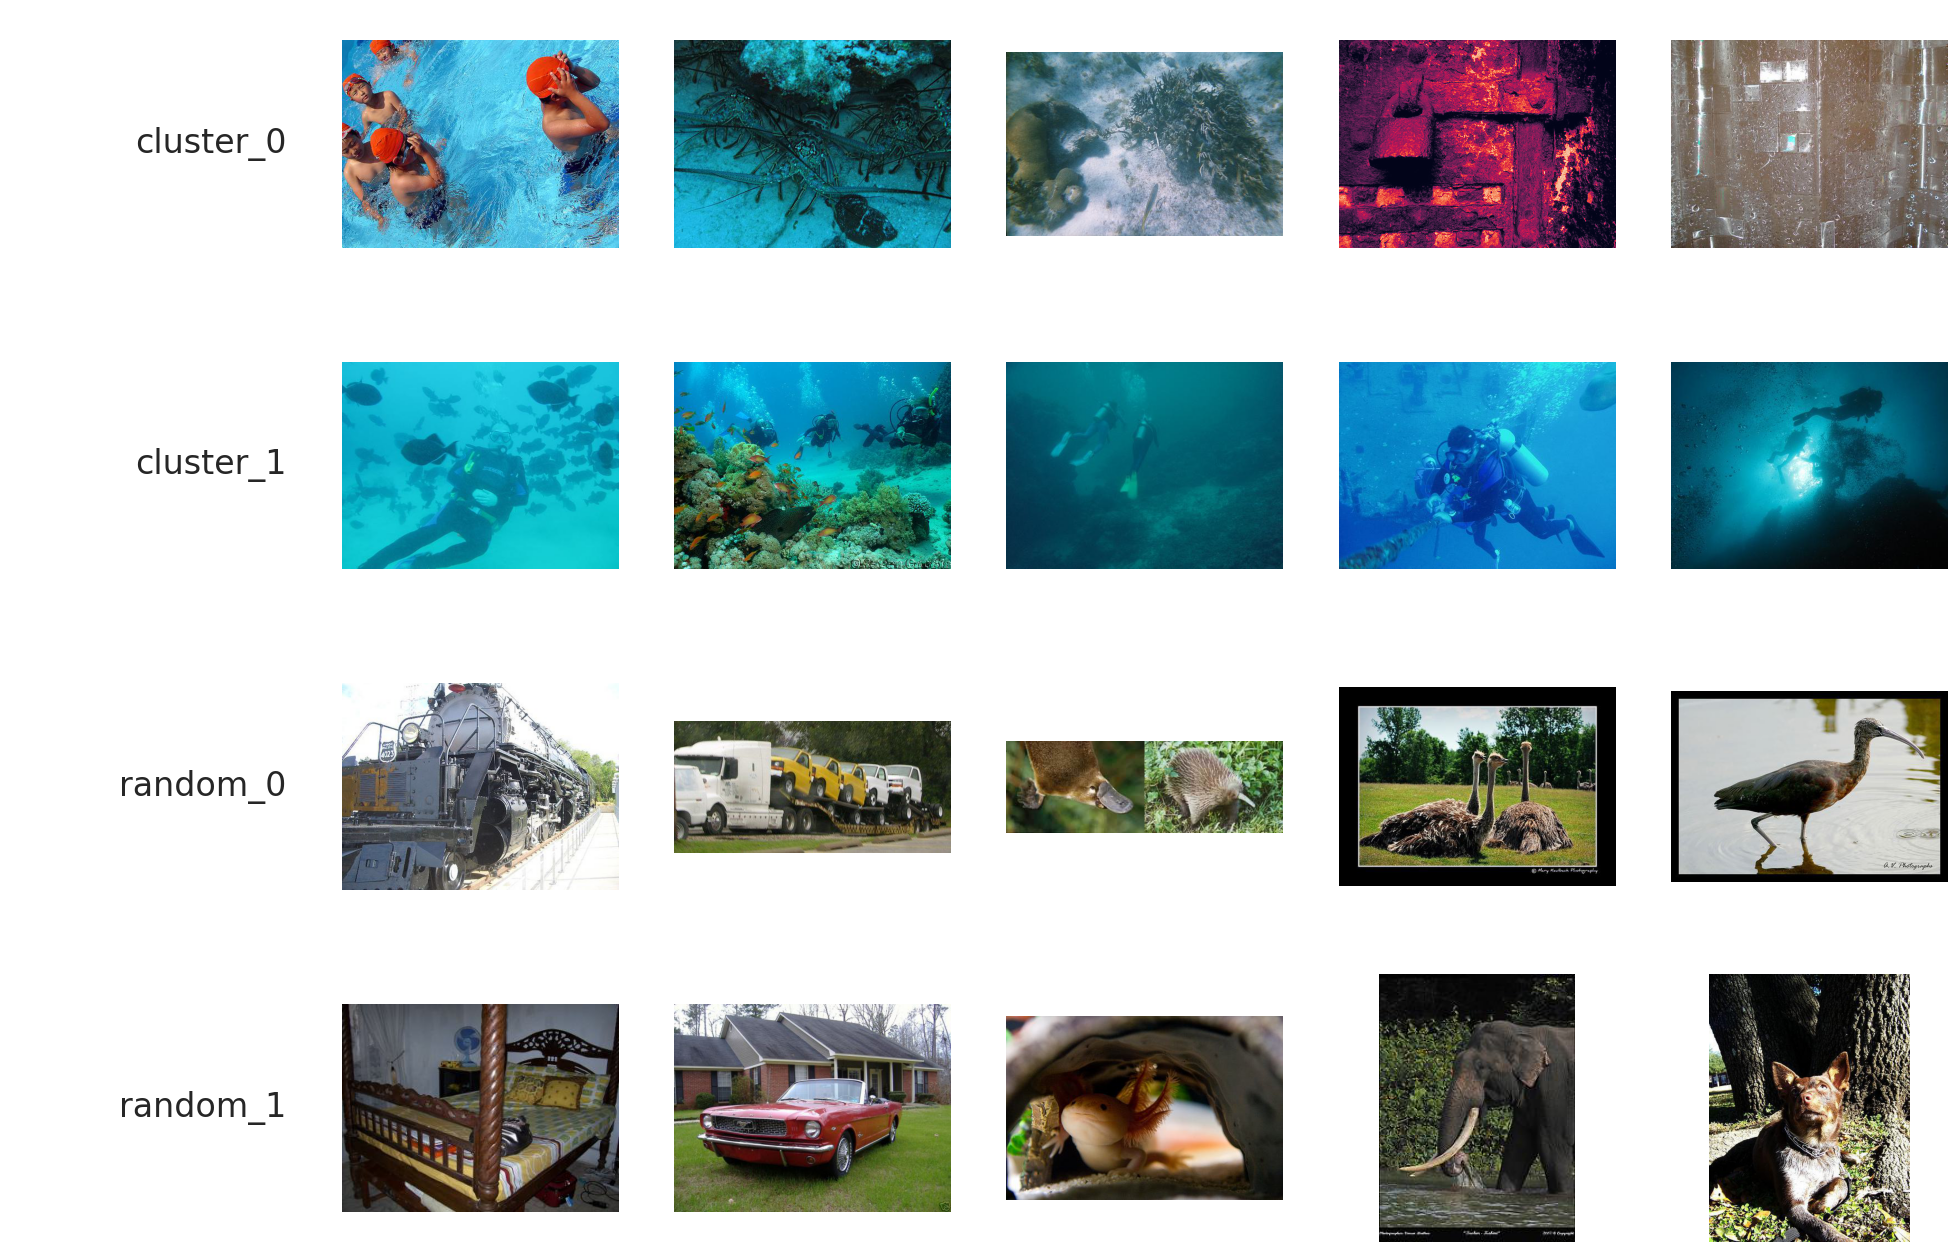

In [58]:
import glob
n_figs = 5
n_concepts = 4

fig, axs = plt.subplots(n_concepts, n_figs + 1, figsize = (25, 4 * n_concepts))

for c, concept in enumerate([cl0_concept, cl1_concept, rand0_concept, rand1_concept]):
    concept_path = os.path.join(concepts_path, concept.name) + "/"
    img_files = glob.glob(concept_path + '*')
    for i, img_file in enumerate(img_files[:n_figs + 1]):
        if os.path.isfile(img_file):
            if i == 0:
                axs[c, i].text(1.0, 0.5, str(concept.name), ha='right', va='center', family='sans-serif', size=24)
            else:
                img = plt.imread(img_file)
                axs[c, i].imshow(img)

            axs[c, i].axis('off')

In [59]:
model = torch.hub.load('pytorch/vision:v0.9.0', 'inception_v3', pretrained=True)
model.eval()

Using cache found in /home/laura/.cache/torch/hub/pytorch_vision_v0.9.0
/home/laura/anaconda3/envs/sw-interpretability/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/laura/anaconda3/envs/sw-interpretability/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [60]:
googlenet = torchvision.models.googlenet(pretrained=True)
googlenet = model.eval()
googlenet

/home/laura/anaconda3/envs/sw-interpretability/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [61]:
from captum.attr import LayerGradientXActivation, LayerIntegratedGradients

mytcav = TCAV(model=model,
              layers=['Mixed_7b'],
#               layers=['Mixed_7b.branch1x1.conv',
#                       'Mixed_7b.branch3x3_2a.conv','Mixed_7b.branch3x3_2b.conv',
#                       'Mixed_7b.branch3x3dbl_3a.conv','Mixed_7b.branch3x3dbl_3b.conv',
#                       'Mixed_7b.branch_pool.conv'],
              layer_attr_method = LayerIntegratedGradients(
                model, None, multiply_by_inputs=False), 
              save_path=f'{SAVEFOLD}concept_ims_neuron_{neuron}/cav')

/home/laura/sw-interpretability/src/captum/captum/concept/_utils/classifier.py:130: UserWarning: Using default classifier for TCAV which keeps input both train and test datasets in the memory. Consider defining your own classifier that doesn't rely heavily on memory, for large number of concepts, by extending `Classifer` abstract class
  warnings.warn(


In [62]:
experimental_set_rand = [[cl0_concept, rand0_concept], [cl1_concept, rand1_concept]]

In [63]:
# Load sample images from folder
def load_image_tensors(root_path=f'{SAVEFOLD}concept_ims_neuron_{neuron}/top_ims/', transform=True):
    path = os.path.join(root_path)
    filenames = glob.glob(path + '/*.JPEG')

    tensors = []
    for filename in filenames:
        #print(filename)
        img = Image.open(filename).convert('RGB')
        tensors.append(transform(img) if transform else img) ### doesn't work if transform= True
    
    return tensors
top_ims_test = load_image_tensors(transform=False)

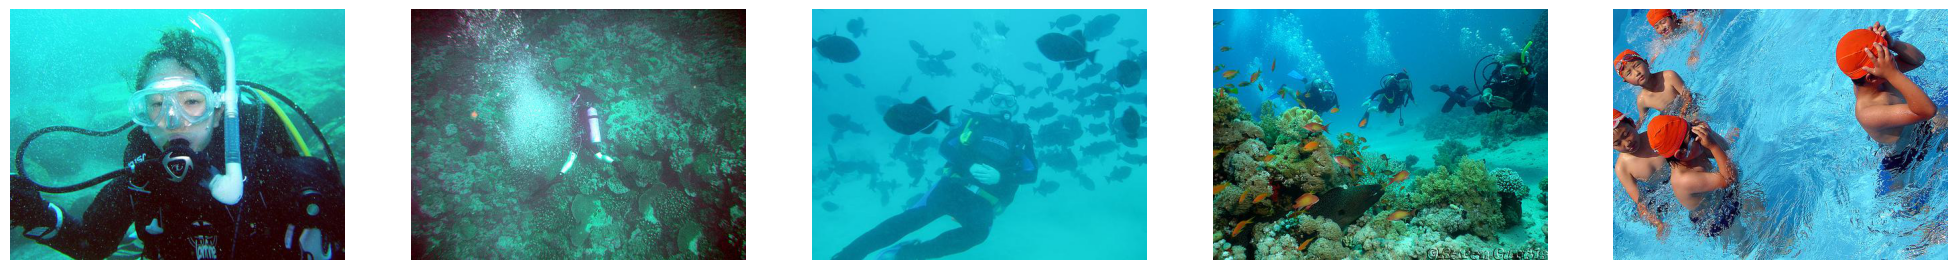

In [64]:
fig, axs = plt.subplots(1, 5, figsize = (25, 5))
axs[0].imshow(top_ims_test[0])
axs[1].imshow(top_ims_test[1])
axs[2].imshow(top_ims_test[2])
axs[3].imshow(top_ims_test[3])
axs[4].imshow(top_ims_test[4])

axs[0].axis('off')
axs[1].axis('off')
axs[2].axis('off')
axs[3].axis('off')
axs[4].axis('off')

plt.show()

In [65]:
# Load sample images from folder
# top_ims_tensors = torch.stack([transform_normalize(transform(img)) for img in top_ims_test])
# experimental_set_rand

In [66]:
# tcav_scores_w_random = mytcav.interpret(inputs=top_ims_tensors,
#                                         experimental_sets=experimental_set_rand,
#                                         #target=zebra_ind,
#                                         n_steps=5,
#                                        )
# tcav_scores_w_random

In [67]:
mytcav.compute_cavs(experimental_set_rand)

/home/laura/sw-interpretability/src/captum/captum/_utils/models/linear_model/train.py:351: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525552411/work/torch/csrc/utils/tensor_new.cpp:230.)
  bias_values = torch.FloatTensor([sklearn_model.intercept_]).to(  # type: ignore


defaultdict(<function captum.concept._core.tcav.TCAV.__init__.<locals>.<lambda>()>,
            {'0-2': defaultdict(None,
                         {'Mixed_7b': <captum.concept._core.cav.CAV at 0x7fad8e8bbeb0>}),
             '1-3': defaultdict(None,
                         {'Mixed_7b': <captum.concept._core.cav.CAV at 0x7fad8e8bbd90>})})

https://captum.ai/api/concept.html

generate_activations(concept_layers)

generate_activations(concept_layers)

generate_all_activations()

load_cavs(concepts)

In [68]:
from captum.concept import ConceptInterpreter
ConceptInterpreter(model)